# Segmentation Study
Segmentation study is used to determine the difference in behaviour between existing segments or identifying population segments as unsupervised learning. I have decided to identify the new population segments in this study.

In [1]:
import pandas as pd

salary = pd.read_csv("au_train.csv")
salary.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelBinarizer

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x[self.attribute_names].values

    
class CustomIndicator(BaseEstimator, TransformerMixin):
    def __init__(self, data):
        self.data = data

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return LabelBinarizer().fit(self.data).transform(x)


numerics = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
numeric_pl = Pipeline([
    ('selector', DataFrameSelector(numerics)),
    ('std_scale', StandardScaler()),
])
workclass_pl = Pipeline([
    ('selector', DataFrameSelector(["workclass"])),
    ('label_indicator', CustomIndicator(salary["workclass"])),
])
marital_pl = Pipeline([
    ('selector', DataFrameSelector(["marital-status"])),
    ('label_indicator', CustomIndicator(salary["marital-status"])),
])
occupation_pl = Pipeline([
    ('selector', DataFrameSelector(["occupation"])),
    ('label_indicator', CustomIndicator(salary["occupation"])),
])
relationship_pl = Pipeline([
    ('selector', DataFrameSelector(["relationship"])),
    ('label_indicator', CustomIndicator(salary["relationship"])),
])
race_pl = Pipeline([
    ('selector', DataFrameSelector(["race"])),
    ('label_indicator', CustomIndicator(salary["race"])),
])
sex_pl = Pipeline([
    ('selector', DataFrameSelector(["sex"])),
    ('label_indicator', CustomIndicator(salary["sex"])),
])
country_pl = Pipeline([
    ('selector', DataFrameSelector(["native-country"])),
    ('label_indicator', CustomIndicator(salary["native-country"])),
])
class_pl = Pipeline([
    ('selector', DataFrameSelector(["class"])),
    ('label_indicator', CustomIndicator(salary["class"])),
])
full_pipeline = FeatureUnion(transformer_list=[
    ("numeric_pl", numeric_pl),
    ("workclass_pl", workclass_pl),
    ("marital_pl", marital_pl),
    ("occupation_pl", occupation_pl),
    ("relationship_pl", relationship_pl),
    ("race_pl", race_pl),
    ("sex_pl", sex_pl),
    ("country_pl", country_pl),
    ("class_pl", country_pl),
])
x = full_pipeline.fit_transform(salary)

d:\project\aunalytics\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\project\aunalytics\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


The same training data set with the same pipeline was used to prepare data for the EM (expectation maximization) clustering algorithm.

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

params, score, silhouette, bic = range(2, 20), [], [], []
for k in params:
    print(k)
    cluster = GaussianMixture(n_init=5, random_state=7, n_components=k)
    cluster.fit(x)
    score.append(cluster.score(x))
    silhouette.append(silhouette_score(x, cluster.predict(x)))
    bic.append(cluster.bic(x))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


The EM algorithms was used for identifying from 2 to 19 clusters and the cluster score and BIC (bayesian information criterion) metrics was collected to identify the potential number of clusters. Both cluster score and BIC metrics indicate that 6 clusters can be a potential interest, both metrics significantly improves up to 6 clusters and then improvement is slowing down.

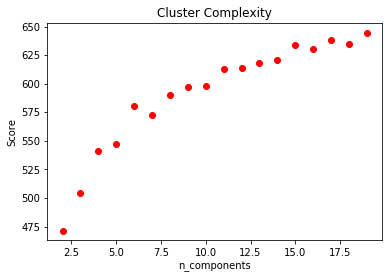

In [19]:
import matplotlib.pyplot as plt

plt.plot(params, score, "ro")
plt.title("Cluster Complexity")
plt.xlabel("n_components")
_ = plt.ylabel("Score")

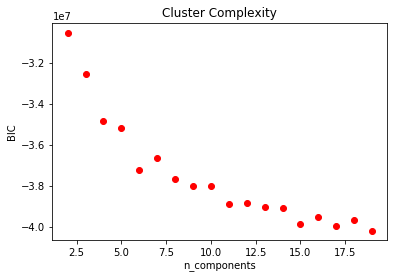

In [17]:
plt.plot(params, bic, "ro")
plt.title("Cluster Complexity")
plt.xlabel("n_components")
_ = plt.ylabel("BIC")

In [29]:
cluster = GaussianMixture(n_init=5, n_components=6)
salary["cluster"] = cluster.fit_predict(x)
print(salary["cluster"].value_counts())

2    18857
5     7758
1     2823
3     1800
0     1164
4      159
Name: cluster, dtype: int64


Above the 6 cluster solution was created and the scatter plot of 'age' vs 'fnlwgt' with clustering is displayed. Further analysis should be done on categorical attributes to identify more precisely each cluster and it largely depends on the purpose of the segmentation study.

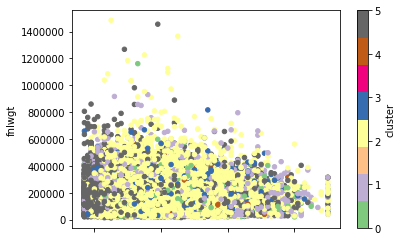

In [30]:
salary_num = salary[["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week","cluster"]].copy()
_ = salary_num.plot(kind="scatter", x="age", y="fnlwgt", c="cluster", cmap=plt.get_cmap("Accent"))